Creating a catplot in seaborn
https://seaborn.pydata.org/tutorial/categorical.html

The Case:
    You've been tasked by your boss at the animal shelter to provide some figures and suggestions on how to best use new funds for your cat department that the shelter will be requesting this coming quarter. They want to know if they should be investing in kitten play places, accessible litter boxes for older cats, or maybe a new sugrical wing for medical care to include spaying and nuetering cats. You are expected to give suggestions along with data to a set of board members who include some community memebers, a vet, some intake specialists, and the director of the shelter.

In [1]:
#import your stuff
import pandas as pd #used to manipulate dataframes
import seaborn as sns #used to manage visualizations
import matplotlib.pyplot as plt #seaborn is based on this and will need it to run.
sns.set_theme(style="ticks", color_codes=True) #this just sets the generic styling, you can change this in a variety of ways to your liking

What is a catplot?
Well, it is not a cat. "Cat" in this case is short for categorical. We can use catplots to vizualize a variety of different  categorical data. These include:
- Categorical Scatter (default)
- Bar charts
- Box Charts
- Boxen Charts
- Violin Plot
- Swarm Plot
- Point Plot

So for the fun of it, let's use data related to cats for our catplots. I'll start with searching for "Open Texas Data" because you can get most governement data in some form of open source data from federal down to city levels thse days. I mean using the fischer iris data set is fun and all, but let's get a challenge.

In [2]:
#here's some data about animal intakes from the Austin Animal Center... you can actually just use the API link
#and read the thing in as a csv which will give us the last 100 entries.
df = pd.read_csv("https://data.austintexas.gov/resource/wter-evkm.csv")
df.shape

(1000, 12)

In [3]:
#now let's just get all the cats
df = df[df['animal_type'] == "Cat"]
df.shape
print('The earliest date of intake for a cat was ' + str(df.datetime.min()))
print('The latest date of intake for a cat was ' + str(df.datetime.max()))
display(df.describe())

The earliest date of intake for a cat was 2021-05-28T15:20:00.000
The latest date of intake for a cat was 2021-06-20T18:13:00.000


,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color
count,488,354,488,488,488,488,488,488,488,488,488,488
unique,483,342,278,278,216,4,7,1,5,31,11,51
top,A835783,*Latte,2021-06-04T15:11:00.000,2021-06-04T15:11:00.000,Austin (TX),Stray,Normal,Cat,Intact Female,1 month,Domestic Shorthair,Black
freq,2,3,9,9,78,377,337,488,216,162,333,69


In [4]:
#what are the breeds that we have?
df['breed'].value_counts()

Domestic Shorthair          333
Domestic Shorthair Mix       84
Domestic Medium Hair         22
Domestic Longhair            16
Domestic Medium Hair Mix     15
Domestic Longhair Mix         6
Siamese                       5
Siamese Mix                   3
Snowshoe Mix                  2
Abyssinian Mix                1
American Curl Shorthair       1
Name: breed, dtype: int64

Ok, so that's a good start. Given that we have 11 cats that are not really clearly called a "long', 'medium', or 'short' hair I think that I will just dump them for the sake of this exercise. Next, I want to standardized the categories. We can use "map" to do that but I think I have a shortcut here.

In [5]:
#drop anything without "domestic" by using a logic statement to filter for only breed values containing the phrase "domestic"
df=df[df['breed'].str.contains('Domestic')]
df['breed'].value_counts()

Domestic Shorthair          333
Domestic Shorthair Mix       84
Domestic Medium Hair         22
Domestic Longhair            16
Domestic Medium Hair Mix     15
Domestic Longhair Mix         6
Name: breed, dtype: int64

Great! Now let's just use the 1st letter of the hair length. looking at this,  I think I will just cut slice that part out. Here's a point I want to interject. Knowing your data and how your engineers are going to manage data is important here. A standard nomenclature means that I could reuse my method or maybe this is a one off adhoc. A work around like this may not be appropriate for a long term, recurring report. Communication matters!

In [6]:
#select the string character at the 9 through 10th positon [recall that the first value starts at 0]
df['breed_abbrv']=df['breed'].str[9:10]

In [7]:
#check the outcome and ensure there were no errors. It's best to do a little math here against the value counts above.
df['breed_abbrv'].value_counts()
# Long = 16 + 6 which is 22... check
# Medium = 23 + 14 = 37... check
# Short = 353 + 79 = 432... check

S    417
M     37
L     22
Name: breed_abbrv, dtype: int64

Now that we have proper categories, let's use the catplot

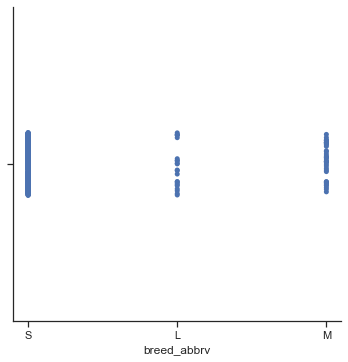

In [8]:
# Scatter plots
sns.catplot(x='breed_abbrv', data=df)

Ok so, we have categories, but I don't really think this shows me anything of value. Why? 
Well, our Y axis in a scatter plot also needs a numerical value even if the x-axis is categorical. Can we use count? Sure but let's look at that. To do that, we need to create a new data frame that contains the counts.

In [9]:
#let's make a new dataframe
df_counts = df['breed_abbrv'].value_counts().to_frame('counts').reset_index().rename(columns = {'index':'breed_abbrv'})

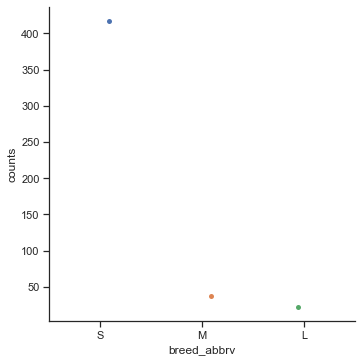

In [10]:
sns.catplot(x='breed_abbrv',y='counts', data=df_counts)

So wait, now we just have three dots? Yup. the number of points in your scatter is equal to the number of observations
or simply put, the rows. The new dataframe is just 3 observations. We had y number of x type of cat. Therefore, we can't use the scatter plot to properly visualize the count of cats. Is it accurate? Sure but it is hard to read for sure. Now let's try a different Y... how about age of the cat at intake?

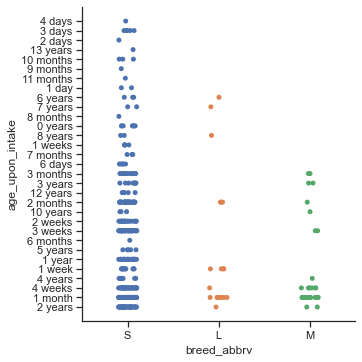

In [11]:
sns.catplot(x='breed_abbrv', y='age_upon_intake',  data=df)

So that's a litte more informative, sort of. Let's clean this up and standardize the ages. Since all the ages are approximate anyways, I'm not too worried if the ages are SUPER accurate. Let's call a year 365 days, a month 30 days, and a week 7 days. I'll start with seperating the strings of the date periods (days, weeks, months, years) from the numeric value. I'll assign those the aforementioned modifiers. After that I can multiply the modifier and the numeric to get an approximate age in days. 

Therefore:
- 2 months would become 2 X 30 days = 60 days
- 5 years would become 5 X 365 = 1825 days

and so on

In [12]:
# since we have a combinate of numbers and letters that are not standard in...
# length we need to use split and " "
df[['age_int', 'age_mod']] = df['age_upon_intake'].str.split(' ', expand=True)
df['age_int']=df['age_int'].astype('float')

In [13]:
#map modifiers to the age_mod column
df['age_mod'] = df['age_mod'].map({'weeks':7, 'week': 7, 'months':30, 'month': 30, 'years':365, 'year':365})

In [14]:
# multiply the modifier and the numeric to get the age in days and then drop any of the rows with a null value
df['age_in_days'] = (df['age_mod']*df['age_int'])
df['age_in_days'].dropna(inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476 entries, 0 to 999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   animal_id         476 non-null    object 
 1   name              343 non-null    object 
 2   datetime          476 non-null    object 
 3   datetime2         476 non-null    object 
 4   found_location    476 non-null    object 
 5   intake_type       476 non-null    object 
 6   intake_condition  476 non-null    object 
 7   animal_type       476 non-null    object 
 8   sex_upon_intake   476 non-null    object 
 9   age_upon_intake   476 non-null    object 
 10  breed             476 non-null    object 
 11  color             476 non-null    object 
 12  breed_abbrv       476 non-null    object 
 13  age_int           476 non-null    float64
 14  age_mod           462 non-null    float64
 15  age_in_days       462 non-null    float64
dtypes: float64(3), object(13)
memory usage: 79.4

In [16]:
# what's the most recent animal and related info
df['datetime'].max()

'2021-06-20T18:13:00.000'

In [17]:
df.datetime.min()

'2021-05-28T15:20:00.000'

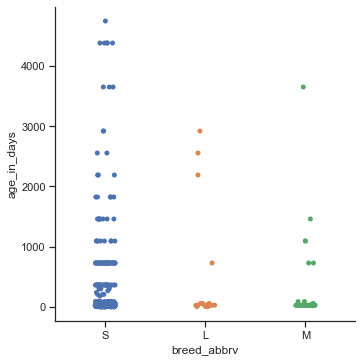

In [18]:
sns.catplot(x='breed_abbrv', y='age_in_days',  data=df)

Now we can see that many pretty all the cats are less than 100 days old upon intake but that those who are VERY old are almost alyways shorthair cats.

If you wanted to make this a bit more "Human Readable" we could convert everything to years either at the mapping phase with altered values where a week is (1/52) of a year a month is 1/12 of a year and a year is a year. At this point I will just divide the age in days by 365.

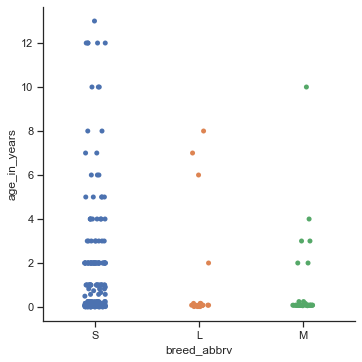

In [19]:
df['age_in_years'] = df['age_in_days']/365
sns.catplot(x='breed_abbrv', y='age_in_years',  data=df)

Now let's talk about the jitter. Jitter is the scattering of the points in slightly variable positions over the graph. This allows us to see the idividual points of the plot even though technically the column is just a single value. Watch what happens when we turn off the "jitter" value by setting it to "False".

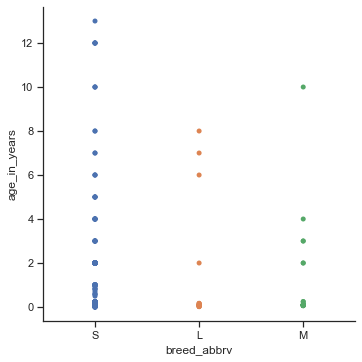

In [20]:
sns.catplot(x='breed_abbrv', y='age_in_years', data=df, jitter=False)

As you can see, we no longer can tell that there are more or less points of data when they overlap. By default, jitter is True and honestly it's best to leave it that way. Times that you might turn the jitter off is if you want to use opacity to signify concentration. We do this by adjusting the alpha value (by default it is set to 1 and the minimum value is 0).

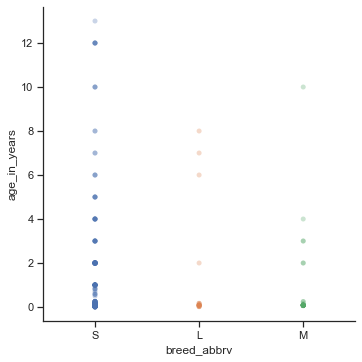

In [21]:
sns.catplot(x='breed_abbrv', y='age_in_years', data=df, jitter=False, alpha = 0.3)

As you can see, the more overlapping points the darker the point becomes. So there's more than one way to skin a cat. 

Swarm plots are the next step from these scatterplots. Essentially a slightly more formal scatter plot with a better jitter, they are very useful in a variety of manners.

C:\Users\JFaulk01\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 71.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\JFaulk01\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\JFaulk01\Miniconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 43.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


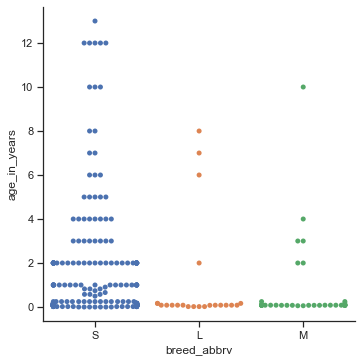

In [22]:
sns.catplot(x='breed_abbrv', y='age_in_years', data=df, kind = 'swarm')

As soon as I run this, I get a lot of warnings from seaborn about this plot. Essentially, in a swarmplot all the points are supposed to be placed with no overlapping. However, since there are way more cats that are 2 years old or less that are surrendered the program cannot place them all without making the graph an unreadable mess. Therefore seaborn didn't and instead showed me a warning message telling me that it didn't place all the points while suggesting I use a different graph. Don't panic, this is fine.

Another option is to use the violin plot. A violin plot is a boxplot with a desnity plot stuck around it. It is named for its tendency to look like a violin. Here's a link to Data Viz Catalogue about it: https://datavizcatalogue.com/methods/violin_plot.html

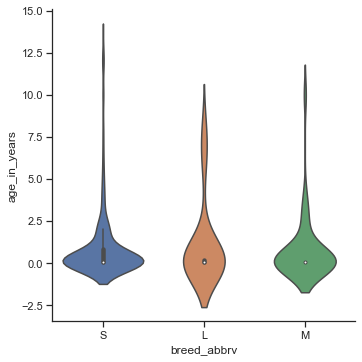

In [23]:
sns.catplot(x='breed_abbrv', y='age_in_years', data=df, kind = 'violin')

With this violin plot, we don't get any warnings, and we can see that clustering of the cats at the lower end of the age range. But then there's this fun issue of cats with negative ages. Wait? How do we have cats with negative ages? if you go back and look at the previous graph, note that we do NOT have cats with negative ages. We can confirm this by observing the minimum value of the age.

In [24]:
df[['age_in_years', 'age_upon_intake']].min()

age_in_years           0.0
age_upon_intake    0 years
dtype: object

Yup. the youngest is 0.0 years old. Okay, so what is going on here? The colored area in violin plots is based on KDE or Kernal Desnisty Estimation. I won't go into that in detail but the important notes are KDE gives a vauge idea what values can be expected based on a finte set of data. Take a look at this page to get more ahnds on details: https://mathisonian.github.io/kde/

Our issue here is that age has a floor value. No one is Benjamin Button, and no one is negative years old. For the sake of your sanity and your audience's sanity let's find a different chart.

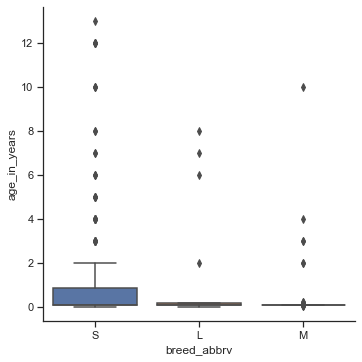

In [25]:
sns.catplot(x='breed_abbrv', y='age_in_years', data=df, kind = 'box')

Ok, ew.... Let's try turning it. I can do this by changing x to y and y to x. and we can adjust the "aspect". Aspect will stretch out the image some. In this case, I will make it 3 in order to try to enlarge the axis and see the boxes more clearly.

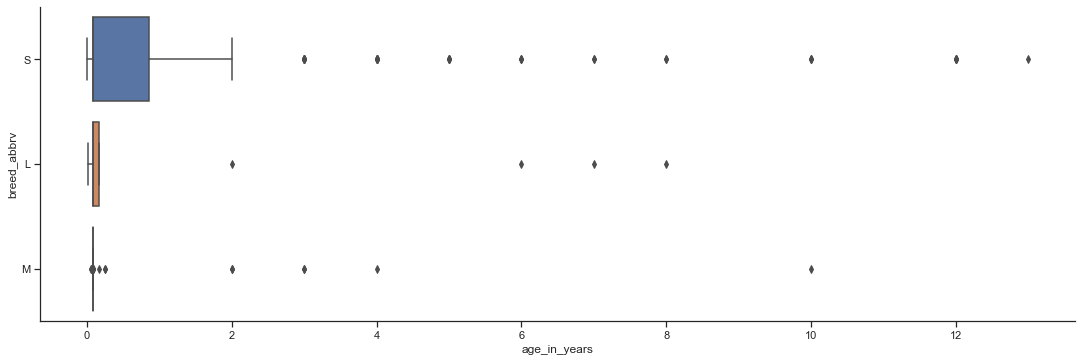

In [26]:
sns.catplot(y='breed_abbrv', x='age_in_years', data=df, kind = 'box', aspect = 3)

So, clearly an issue here is the number of outlier in the above 6 year old range. Another abject failure... Let's do something a little mor complicated. 

- let's remove the aspect changes.
- let's remove the x axis labels
- let's change the y axis back to the age_in_years
- add "col" and use breed_abbrv to create 3 seperate graphs

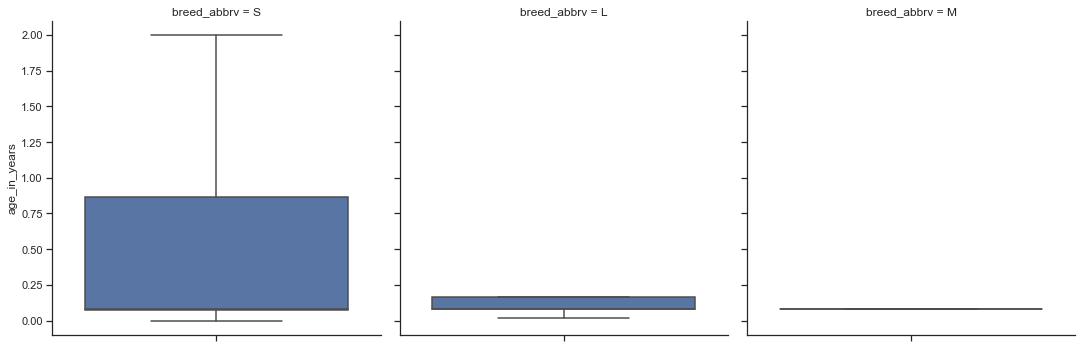

In [27]:
sns.catplot(y='age_in_years', data=df, kind = 'box', col = 'breed_abbrv', showfliers = False)

ok, so I just removed all the outliers. We can report the max ages in a chart or something because my god, who surrenders a.. wait one second

In [28]:
df.loc[df['age_in_years'].idxmax()]

animal_id                                       A836089
name                                            A836089
datetime                        2021-06-05T15:57:00.000
datetime2                       2021-06-05T15:57:00.000
found_location      912 East 39Th Street in Austin (TX)
intake_type                                       Stray
intake_condition                                   Sick
animal_type                                         Cat
sex_upon_intake                           Neutered Male
age_upon_intake                                13 years
breed                                Domestic Shorthair
color                                       Brown Tabby
breed_abbrv                                           S
age_int                                            13.0
age_mod                                           365.0
age_in_days                                      4745.0
age_in_years                                       13.0
Name: 665, dtype: object

15 year old cat... OOF! {at the time that I wrote this}

Anyways, so the above shows us that the age aof the animals is somewhere between 1 and zero years. Let's drill down some. ( we could have just ran descriptive stats at the start, but then how would we have learned all this fun code?)

In [29]:
# convert the days into months
df['age_in_months'] = df['age_in_days']/30

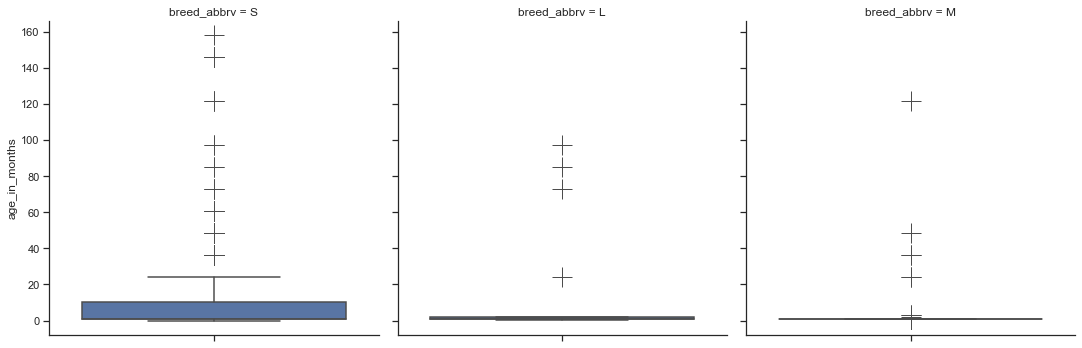

In [30]:
sns.catplot(y='age_in_months',
            data=df,
            kind = 'box',
            col = 'breed_abbrv',
            flierprops = dict(markerfacecolor = '0.50', markersize = 20, marker= '+'),
            meanprops = dict(marker='^'))

Let's review the things that I added to the above code. 
- I added the flierprops which is refferring to the outliers which we turned off earlier with False, but this time I changed the marker and the size etc...
- I added meanprops which just changes the properties of the mean, which you can't see at the moment.
- I formatted the code over several lines because it was getting really big and unruly.

Ok, so let's move on to the Boxen plot. A boxen plot is used for bigger data sets. 

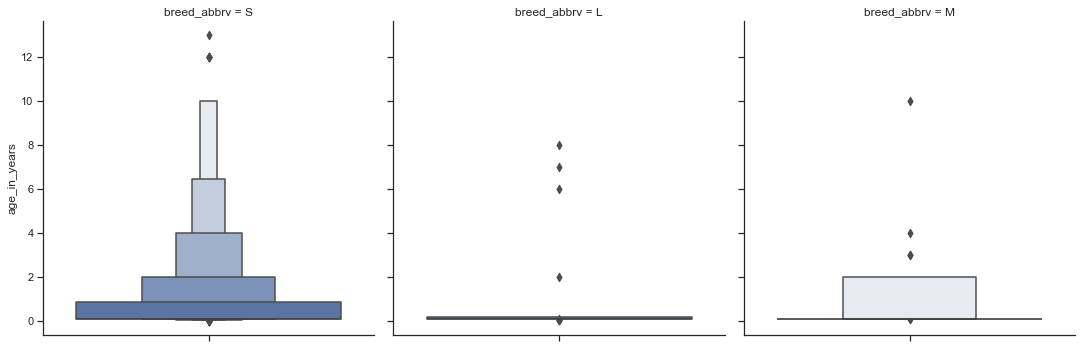

In [31]:
sns.catplot(y='age_in_years',
            data=df,
            kind = 'boxen',
            col = 'breed_abbrv')

Nope, that's still terrible. Let's try removeing the outliers again.

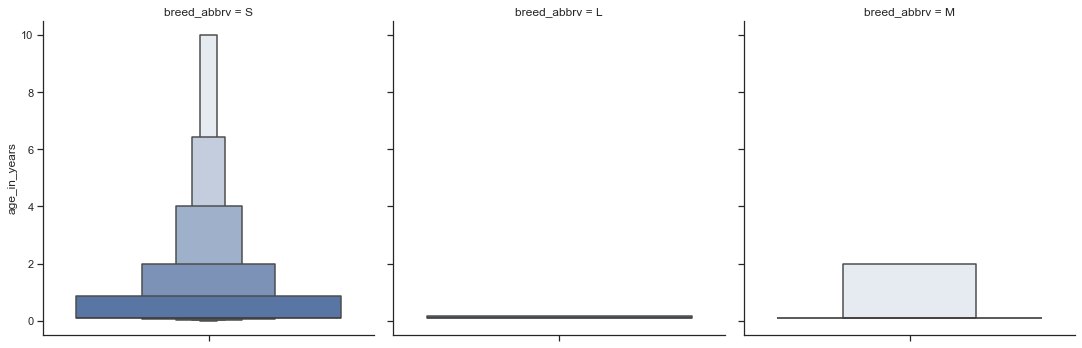

In [32]:
sns.catplot(y='age_in_years',
            data=df,
            kind = 'boxen',
            col = 'breed_abbrv',
           showfliers = False)

This is likely the closest visual we're going to get to today in this mess. Let's continue on in the exercise.

<AxesSubplot:xlabel='age_in_years', ylabel='Count'>

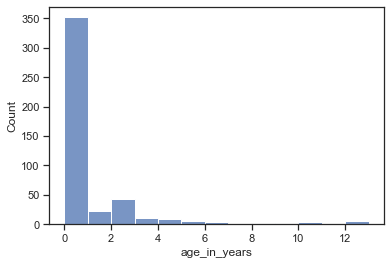

In [33]:
sns.histplot(x='age_in_years', binwidth = 1, data=df)

<AxesSubplot:xlabel='age_in_years', ylabel='Count'>

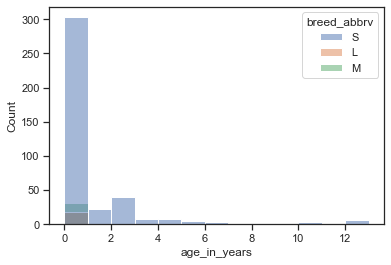

In [34]:
sns.histplot(x='age_in_years', binwidth = 1, data=df, hue='breed_abbrv')

ok so that's hard to see, let's adjust this

<AxesSubplot:xlabel='age_in_years', ylabel='Count'>

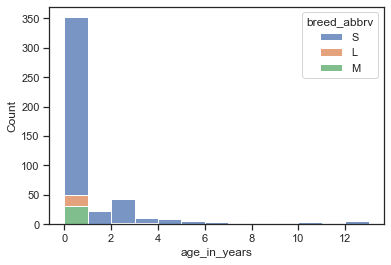

In [35]:
sns.histplot(x='age_in_years', binwidth = 1, data=df, hue='breed_abbrv', multiple='stack')

<AxesSubplot:xlabel='age_in_years', ylabel='Probability'>

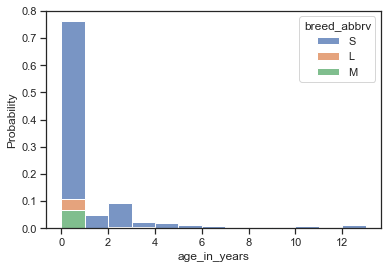

In [36]:
sns.histplot(x='age_in_years', binwidth = 1, data=df, hue='breed_abbrv', multiple='stack', stat='probability')

<AxesSubplot:xlabel='age_in_months', ylabel='Probability'>

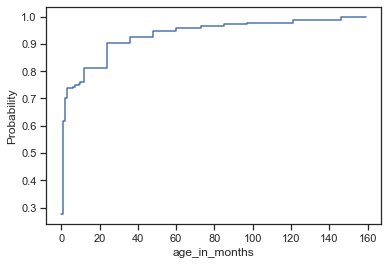

In [37]:
sns.histplot(x='age_in_months', binwidth = 1, data=df, stat='probability', cumulative = True, element='step', fill = False)

OK, enough of that. You get it. You can make pretty mauch all the kinds of histograms

<AxesSubplot:xlabel='sex_upon_intake', ylabel='count'>

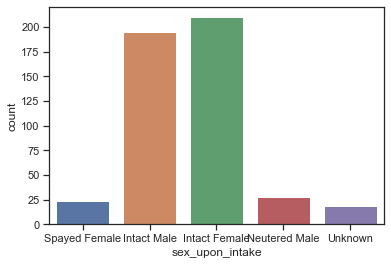

In [38]:
sns.countplot(data = df, x='sex_upon_intake')

Success! But the labels are hard to read. Let's fix that.

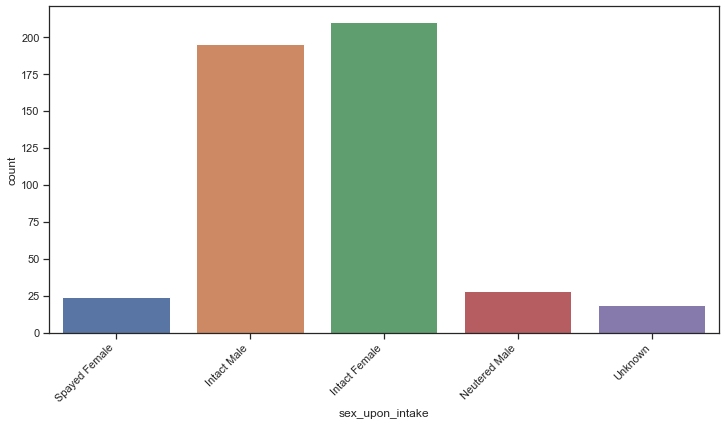

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='sex_upon_intake', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Yes, I see you wondering where and why I added all the extra lines of code. At somepoint, when the modifications to the graph hit a level of sophsiticaiton it is time to switch to using the fig and ax methods. These involve altering figure at the matplotlib level.

Here we've defined the figure and the axis as fig and ax. After creating the count plot, we alter the ax using set_xticklabels by telling it to rotate the labels to a 45 degree angle and align them to the right. plt.show() refers to the matplotlib.pyplot we imported at the start. Show is sort of like print but for the graph. * note that the line of code above the graphic is now gone)

Next I want to add the values to the bars so that I can see the actual counts themselves. 

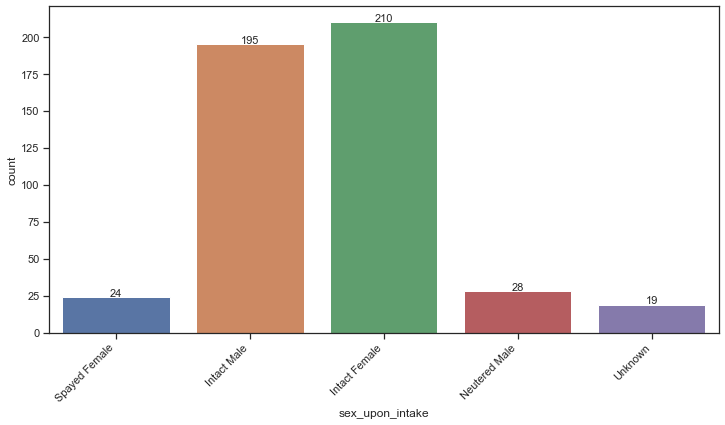

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='sex_upon_intake', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# here we add this loop to alter ax
for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2, # x position
             rect.get_height()+ 0.75, # y position
             rect.get_height(), # the value to display
             horizontalalignment='center', #**kwarg or other option parameters
             fontsize = 11 )#**kwarg or other option parameters

plt.show()

### A Sidebar: What is all that!?
Let's dive into the loop a little more, note that "ax.patches" yields the following.

In [41]:
display(ax.patches)

Even thought the above is not a float value, using ******.get_x() or get_height() will return values. Observe the following:

In [42]:
display(ax.patches[0].get_x()) # this idicates where the bar chart starts in the left side

-0.4

In [43]:
display(ax.patches[0].get_width()) #idicates how far over from the left hand side does other side of the bar go

0.8

In [44]:
ax.patches[0].get_x() + ax.patches[0].get_width()  / 2  # this places the value in the middle of the bar by dividing the width of the bar in half.

0.0

In [45]:
display(ax.patches[0].get_height()+ 0.75) # this will stick the value just above the top of the bar

24.75

In [46]:
display(ax.patches[0].get_height()) # this is the text that is display or in our case the count.

24

I assume that horizontal alignment and fontsize are pretty clear, so let's move on. Now this is a nice graph, but I think we can do better. Let's combine the male and female bars and use color to indicate if the animal was fixed or not. I will add two new columns one for sex and one for fixed. Let's use our handny friend "split" again.

### Returning to Graphs

In [47]:
df[['fixed', 'sex']] = df['sex_upon_intake'].str.split(' ', expand=True)

In [48]:
df.sex.value_counts()

Female    234
Male      223
Name: sex, dtype: int64

In [49]:
df.fixed.value_counts()

Intact      405
Neutered     28
Spayed       24
Unknown      19
Name: fixed, dtype: int64

Again, this is a good moment to add stuff.
sex values = 241 + 230 or 471
fixed values = 419+26+26+22 or 493

wait.... so why are we missing... 493-471 or 22 values in sex?

a big clue is that there were 22 unknowns in the dataset. The split left the sex NULL because there was no  " " *aka a space* in the string to split it on. Let's coalesce the sex column and fill the entries with "Not Determined"

In [50]:
df.sex=df.sex.fillna('Not Specified')
df.sex.value_counts()

Female           234
Male             223
Not Specified     19
Name: sex, dtype: int64

There we go! All 22 are account for now! Let's adjust the fixed values so that spayed and neutered are the same.

In [51]:
df['fixed_TF'] = df['fixed'].isin(['Spayed', 'Neutered']) # Here we are setting up a logic statement to return True if the string matches one in the list

In [52]:
df.fixed_TF.value_counts()

False    424
True      52
Name: fixed_TF, dtype: int64

Notice that the logic statement is not sophisticated enough to determine that 22 of the cases are actually unknown. Adding them to the is in statement will not work either, as this will just return True instead of False. Instead, lets go back to our handy map statement.

In [53]:
df.fixed_TF=df.fixed.map({'Unknown': 'Not Specified'})
df.fixed_TF.value_counts()

Not Specified    19
Name: fixed_TF, dtype: int64

Looks like we have to map all possible values or they show up NULL

In [54]:
df.fixed_TF=df.fixed.map({'Unknown': 'Not Specified', 'Spayed': True, 'Neutered': True, 'Intact': False})
df.fixed_TF.value_counts()

False            405
True              52
Not Specified     19
Name: fixed_TF, dtype: int64

Now our values add up correctly! Let's move back into graphing.

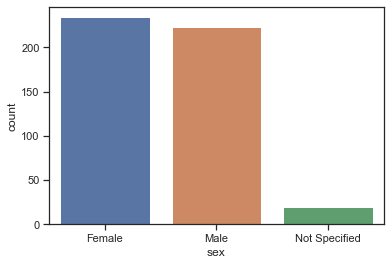

In [55]:
sns.countplot(data = df, x='sex')
plt.show()

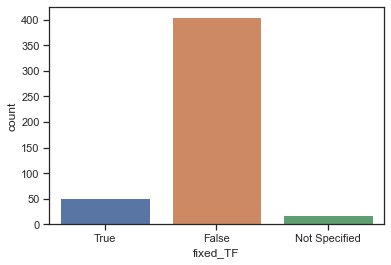

In [56]:
sns.countplot(data = df, x='fixed_TF')
plt.show()

Now let's set about making a better graph from these two.

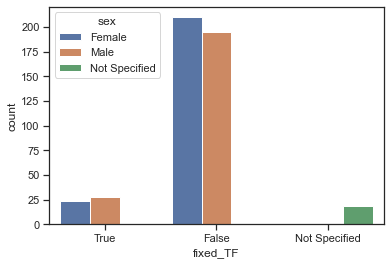

In [57]:
sns.countplot(data = df, x='fixed_TF', hue = 'sex')
plt.show()

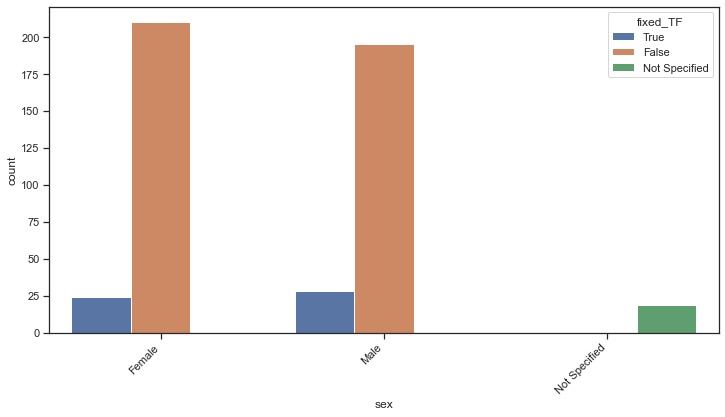

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='sex', hue = 'fixed_TF', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

 Same data, but very different looking charts. The on you pick will depend on the situation. In our case, I would select the one where sex is the hue and fixed_tf is the x axis. It shows that male and female cats are nearly identical except that female cats are a little more likely to come into the shelter not spayed.

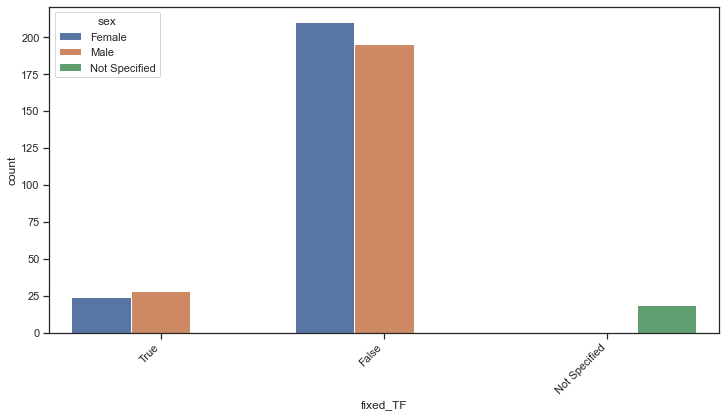

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='fixed_TF', hue = 'sex', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# Timeseries

Timeseries data is anything related to a date (essentially). We want to know what days of the week are the busiest, so the shelter can assess staffing needs for the intake department. Additionally, they want to know if holidays are busier or less so than normal.

With our truncated dataset, we may have some trouble, but we are going to take a stab at it.

In this dataset there are two timeseries datetime and datetime2. Let's look a little deeper.

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   animal_id         476 non-null    object 
 1   name              343 non-null    object 
 2   datetime          476 non-null    object 
 3   datetime2         476 non-null    object 
 4   found_location    476 non-null    object 
 5   intake_type       476 non-null    object 
 6   intake_condition  476 non-null    object 
 7   animal_type       476 non-null    object 
 8   sex_upon_intake   476 non-null    object 
 9   age_upon_intake   476 non-null    object 
 10  breed             476 non-null    object 
 11  color             476 non-null    object 
 12  breed_abbrv       476 non-null    object 
 13  age_int           476 non-null    float64
 14  age_mod           462 non-null    float64
 15  age_in_days       462 non-null    float64
 16  age_in_years      462 non-null    float64
 1

We can use the information published with the dataset to get a clearer picture. https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm

Under "Columns in this dataset" you will find information about each column including API Field Name. For our issue we want to identify which columns are datetime and datetime2. We see that datetime corresponds with datetime, but datetime2 is actually "monthyear" in the dataset. Let's print the head and take a look at that now.

In [61]:
df.head()

,animal_id,name,datetime,datetime2,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,...,color,breed_abbrv,age_int,age_mod,age_in_days,age_in_years,age_in_months,fixed,sex,fixed_TF
0,A795732,*Miss Kitty,2021-06-20T18:13:00.000,2021-06-20T18:13:00.000,12428 Sky Harbart Del Valley in Leander (TX),Stray,Normal,Cat,Spayed Female,2 years,...,Black Smoke,S,2.0,365.0,730.0,2.000000,24.333333,Spayed,Female,True
3,A837250,837250,2021-06-20T14:53:00.000,2021-06-20T14:53:00.000,Near The Airport in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,...,Orange Tabby,S,1.0,30.0,30.0,0.082192,1.000000,Intact,Male,False
4,A837251,A837251,2021-06-20T14:53:00.000,2021-06-20T14:53:00.000,Near The Airport in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,...,Orange Tabby/White,S,1.0,30.0,30.0,0.082192,1.000000,Intact,Female,False
5,A837252,A837252,2021-06-20T14:53:00.000,2021-06-20T14:53:00.000,Near The Airport in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,...,Orange Tabby/White,L,1.0,30.0,30.0,0.082192,1.000000,Intact,Male,False
6,A837253,A837253,2021-06-20T14:53:00.000,2021-06-20T14:53:00.000,Near The Airport in Austin (TX),Stray,Normal,Cat,Intact Female,1 month,...,Torbie,S,1.0,30.0,30.0,0.082192,1.000000,Intact,Female,False


Clearly, they didn't actually truncate the data and we have a duplicated column. Let's ignore the datetime2 column entirely for the rest of the exercise.

In [62]:
# Convert the datetime string to a datetime field
df['datetime']= pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 476 entries, 0 to 999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   animal_id         476 non-null    object        
 1   name              343 non-null    object        
 2   datetime          476 non-null    datetime64[ns]
 3   datetime2         476 non-null    object        
 4   found_location    476 non-null    object        
 5   intake_type       476 non-null    object        
 6   intake_condition  476 non-null    object        
 7   animal_type       476 non-null    object        
 8   sex_upon_intake   476 non-null    object        
 9   age_upon_intake   476 non-null    object        
 10  breed             476 non-null    object        
 11  color             476 non-null    object        
 12  breed_abbrv       476 non-null    object        
 13  age_int           476 non-null    float64       
 14  age_mod           462 non-

In [63]:
# change the datetime to the name of the day name 
df['day_name']=df.datetime.dt.day_name()

Now we can use the count plot with the day_name field to see how many intakes occured on which days of the week

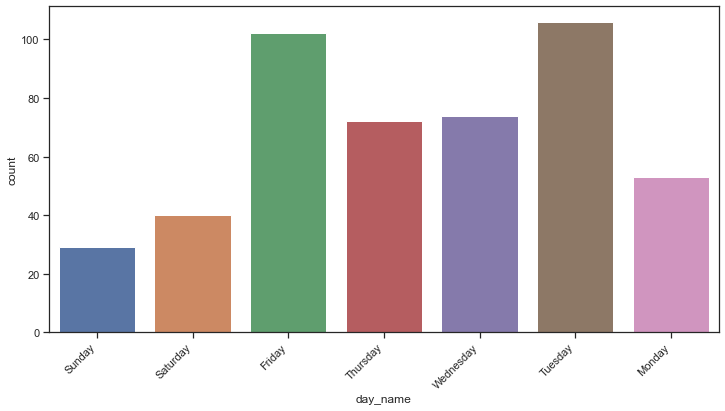

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='day_name', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Well, that's a good start but the days are out of order. Let's fix that by setting them manually using "Order" which is just a list of the label names in order of how you want them.

In [65]:
day_order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

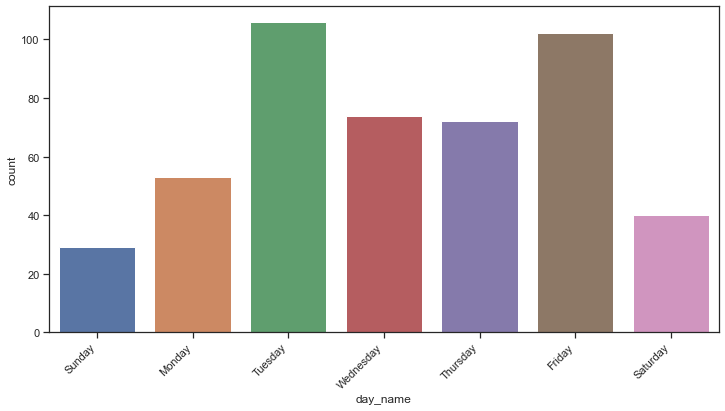

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(data=df, x='day_name', ax=ax, order=day_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Wait a minute, maybe there was a week that exceptional. Was there a tuesday of note in the last 30 days or so? Let's use a line graph instead and visualize each week as a seperate line.

In [67]:
df['week'] = df.datetime.dt.isocalendar().week
df['day_num']=df.datetime.dt.dayofweek

In [68]:
week_count = df.groupby(['week','day_num'])['animal_id'].count().reset_index().rename(columns = {'animal_id':'count'})

This time I will add the title, x label, and the y label using pyplot.

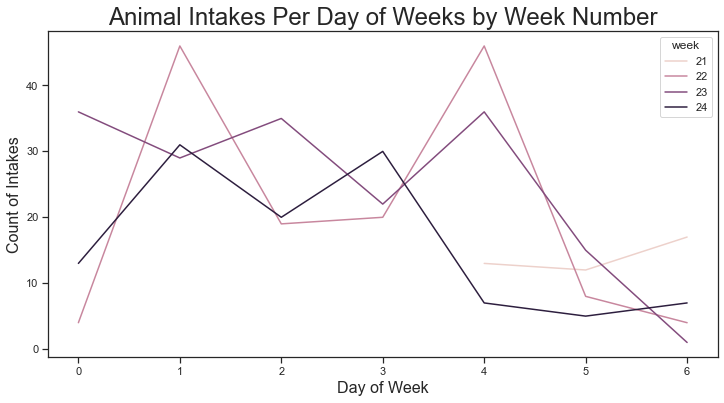

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))
fig= sns.lineplot(x="day_num",
             y="count",
             hue='week',
             data=week_count)
plt.title('Animal Intakes Per Day of Weeks by Week Number', size=24)
plt.xlabel('Day of Week', size=16)
plt.ylabel('Count of Intakes', size=16)
plt.show()

#https://datagy.io/seaborn-line-plot/

ok, so that's helpful. Let's make a crosstab to see the actual numbers of the graph above. We can confirm that Tuesday and Friday are the days with the most intakes.

In [70]:
pd.crosstab(df.week, [df.day_num, df.day_name], margins = True)

day_num,0,1,2,3,4,5,6,All
day_name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,
week,,,,,,,,
21,0,0,0,0,13,12,17,42
22,4,46,19,20,46,8,4,147
23,36,29,35,22,36,15,1,174
24,13,31,20,30,7,5,7,113
All,53,106,74,72,102,40,29,476


In [71]:
pd.crosstab( df.intake_type,[df.day_num, df.day_name], margins = True)

day_num,0,1,2,3,4,5,6,All
day_name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,
intake_type,,,,,,,,
Abandoned,5,4,2,3,6,0,7,27
Owner Surrender,10,10,13,7,32,3,2,77
Public Assist,1,1,0,0,0,3,1,6
Stray,37,91,59,62,64,34,19,366
All,53,106,74,72,102,40,29,476


Let's look just at kittens now by filtering to cats 1 year or less.

In [72]:
print((df['age_in_years']<= 1).sum()/df['age_in_years'].notnull().sum().round(2)*100)
print('approximate amount are kittens')

81.16883116883116
approximate amount are kittens


In [73]:
kittens = df[(df['age_in_years']<= 1)]

In [74]:
kittens.describe()

,age_int,age_mod,age_in_days,age_in_years,age_in_months,week,day_num
count,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000,375.000000
mean,1.984000,49.440000,58.845333,0.161220,1.961511,22.744000,2.594667
std,1.552903,93.770005,88.412999,0.242227,2.947100,0.918357,1.753826
min,0.000000,7.000000,0.000000,0.000000,0.000000,21.000000,0.000000
25%,1.000000,7.000000,28.000000,0.076712,0.933333,22.000000,1.000000
50%,1.000000,30.000000,30.000000,0.082192,1.000000,23.000000,3.000000
75%,3.000000,30.000000,30.000000,0.082192,1.000000,23.000000,4.000000
max,11.000000,365.000000,365.000000,1.000000,12.166667,24.000000,6.000000


In [75]:
kittens.loc[kittens['age_int'].idxmax()]

animal_id                                                A836336
name                                                         NaN
datetime                                     2021-06-08 10:16:00
datetime2                                2021-06-08T10:16:00.000
found_location      1156 West Cesar Chavez Street in Austin (TX)
intake_type                                                Stray
intake_condition                                          Normal
animal_type                                                  Cat
sex_upon_intake                                    Intact Female
age_upon_intake                                        11 months
breed                                         Domestic Shorthair
color                                                Brown Tabby
breed_abbrv                                                    S
age_int                                                     11.0
age_mod                                                     30.0
age_in_days              

<AxesSubplot:xlabel='age_in_days', ylabel='Count'>

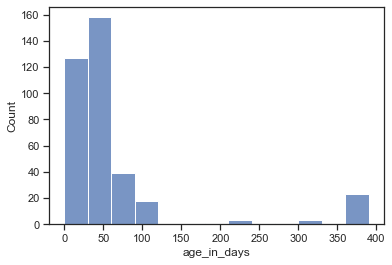

In [76]:
sns.histplot(x='age_in_days', binwidth = 30, data=kittens)

<AxesSubplot:xlabel='age_in_days', ylabel='Count'>

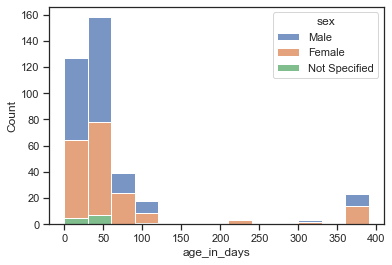

In [77]:
sns.histplot(x='age_in_days', hue = 'sex', multiple='stack', binwidth = 30, data=kittens)

In [78]:
cats = df[~(df['age_in_years']<= 1)]

<AxesSubplot:xlabel='age_in_years', ylabel='Count'>

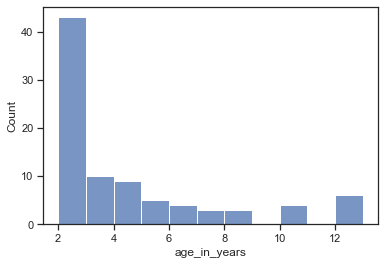

In [79]:
sns.histplot(x='age_in_years', binwidth = 1, data=cats)

<AxesSubplot:xlabel='age_in_years', ylabel='Count'>

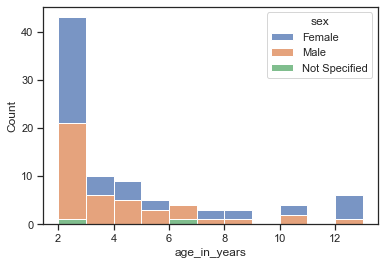

In [80]:
sns.histplot(x='age_in_years', hue = 'sex', multiple='stack', binwidth = 1, data=cats)

In [81]:
df['kitten'] = df['age_in_years']<= 1

<AxesSubplot:xlabel='kitten', ylabel='count'>

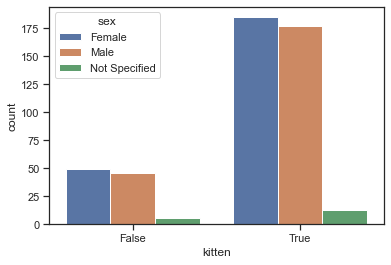

In [82]:
sns.countplot(x='kitten', hue='sex', data=df)

ok, so that was fun, but what we really need is to look at some longer term data. 1000 entries is not cutting it. Let's go back to the data site and download the data. I will also stake this time to grab the outcomes data too! This time we will explictly tell pandas to read the DateTime column as a datetime.

In [83]:
intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv', parse_dates=['DateTime'])

In [84]:
outcomes = pd.read_csv('Austin_Animal_Center_Outcomes.csv', parse_dates=['DateTime'])

In [85]:
# Are there repeated intakes?
# prints filtered value_counts for the column
intakes['Animal ID'].value_counts().loc[lambda x : x>1] 

#yes, so let's filter these to the most recent visit
recent_intakes=intakes.loc[intakes.groupby('Animal ID').DateTime.idxmax(),:]
display(recent_intakes)
print('Are the duplicates removed??')
dupes= recent_intakes['Animal ID'].value_counts().loc[lambda x : x>1]
print(dupes.empty)

,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
18630,A006100,Scamp,2017-12-07 14:07:00,12/07/2017 02:07:00 PM,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White
65383,A047759,Oreo,2014-04-02 15:55:00,04/02/2014 03:55:00 PM,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10 years,Dachshund,Tricolor
88932,A134067,Bandit,2013-11-16 09:02:00,11/16/2013 09:02:00 AM,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White
38450,A141142,Bettie,2013-11-16 14:46:00,11/16/2013 02:46:00 PM,Austin (TX),Stray,Aged,Dog,Spayed Female,15 years,Labrador Retriever/Pit Bull,Black/White
117785,A163459,Sasha,2014-11-14 15:11:00,11/14/2014 03:11:00 PM,Ih 35 And 41St St in Austin (TX),Stray,Normal,Dog,Intact Female,15 years,Miniature Schnauzer Mix,Black/Gray
...,...,...,...,...,...,...,...,...,...,...,...,...
127507,A837067,NaN,2021-06-17 09:16:00,06/17/2021 09:16:00 AM,8621 Neider Drive in Austin (TX),Stray,Sick,Cat,Intact Male,2 months,Domestic Shorthair,White/Orange
127510,A837068,NaN,2021-06-17 10:04:00,06/17/2021 10:04:00 AM,11408 Cozette Dr in Travis (TX),Stray,Sick,Cat,Unknown,3 months,Domestic Shorthair,Gray Tabby
127513,A837072,NaN,2021-06-17 11:07:00,06/17/2021 11:07:00 AM,18116 Lipan Apache Cove in Austin (TX),Wildlife,Normal,Other,Unknown,3 months,Raccoon,Black/Gray
127524,A837073,Paco,2021-06-17 10:51:00,06/17/2021 10:51:00 AM,Austin (TX),Owner Surrender,Normal,Dog,Unknown,7 years,Rat Terrier Mix,Tricolor


Are the duplicates removed??
True


Or we can just sort the values and keep the last value in the sorted list which will run faster.

In [86]:
sorted = intakes.sort_values('DateTime')
result = sorted.drop_duplicates('Animal ID', keep='last').values
print(result)
col_names=sorted.columns
print(col_names)
recent_intakes = pd.DataFrame(result, columns=col_names)
display(recent_intakes)
print('Are the duplicates removed??')
dupes= recent_intakes['Animal ID'].value_counts().loc[lambda x : x>1]
print(dupes.empty)

[['A521520' 'Nina' Timestamp('2013-10-01 07:51:00') ... '7 years'
  'Border Terrier/Border Collie' 'White/Tan']
 ['A664237' nan Timestamp('2013-10-01 08:33:00') ... '1 week'
  'Domestic Shorthair Mix' 'Orange/White']
 ['A664236' nan Timestamp('2013-10-01 08:33:00') ... '1 week'
  'Domestic Shorthair Mix' 'Orange/White']
 ...
 ['A837009' nan Timestamp('2021-06-17 11:39:00') ... '4 weeks'
  'Domestic Shorthair' 'Black/White']
 ['A837008' nan Timestamp('2021-06-17 11:39:00') ... '4 weeks'
  'Domestic Medium Hair' 'Black/White']
 ['A837007' nan Timestamp('2021-06-17 11:39:00') ... '4 weeks'
  'Domestic Medium Hair' 'Black/White']]
Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found Location',
       'Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake',
       'Age upon Intake', 'Breed', 'Color'],
      dtype='object')


,Animal ID,Name,DateTime,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A521520,Nina,2013-10-01 07:51:00,10/01/2013 07:51:00 AM,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
1,A664237,NaN,2013-10-01 08:33:00,10/01/2013 08:33:00 AM,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01 08:33:00,10/01/2013 08:33:00 AM,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
3,A664235,NaN,2013-10-01 08:33:00,10/01/2013 08:33:00 AM,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
4,A664233,Stevie,2013-10-01 08:53:00,10/01/2013 08:53:00 AM,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White
...,...,...,...,...,...,...,...,...,...,...,...,...
114005,A837012,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Unknown,4 weeks,Domestic Shorthair,White/Black
114006,A837006,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Intact Female,1 year,Domestic Shorthair,Black/White
114007,A837009,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Unknown,4 weeks,Domestic Shorthair,Black/White
114008,A837008,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Unknown,4 weeks,Domestic Medium Hair,Black/White


Are the duplicates removed??
True


So there's a lot of different ways to approach this issue and what you choose will depend on your choice based on your needs.

Again, we can apply this to the outcomes. Then if any negative values for "sehlter_days" are observed or nulls when we join... we have a pet that does not have a resolution at this time. The reason the we can assume that a negative "shelter days" value means the pet is still at the shelter is because the only reason they would have an outcome date BEFORE their most recent intake date is that the pet was returned to the shelter at a later date.

Also, take the time to check and see if the dataframes have the same number of rows in case your methods don't work appropriately. I find that stopping to make these little checks really help me identify if I did something wrong here.

see link: https://stackoverflow.com/questions/9850954/pandas-get-most-recent-value-of-a-particular-column-indexed-by-another-column#22940775

In [87]:
# Are there repeated outcomes?
# prints filtered value_counts for the column
outcomes['Animal ID'].value_counts().loc[lambda x : x>1] 

#yes, so let's remove those

sorted = outcomes.sort_values('DateTime')
result = sorted.drop_duplicates('Animal ID', keep='last').values
print(result)
col_names=sorted.columns
print(col_names)
recent_outcomes = pd.DataFrame(result, columns=col_names)
display(recent_outcomes)
print('Are the duplicates removed??')
dupes= recent_outcomes['Animal ID'].value_counts().loc[lambda x : x>1]
print(dupes.empty)

[['A659834' '*Dudley' Timestamp('2013-10-01 09:31:00') ... '2 months'
  'Labrador Retriever Mix' 'Black']
 ['A664235' nan Timestamp('2013-10-01 10:39:00') ... '1 week'
  'Domestic Shorthair Mix' 'Orange/White']
 ['A664236' nan Timestamp('2013-10-01 10:44:00') ... '1 week'
  'Domestic Shorthair Mix' 'Orange/White']
 ...
 ['A797495' 'Ace' Timestamp('2021-06-17 11:46:00') ... '6 months'
  'Cairn Terrier' 'Black/Tan']
 ['A836849' 'Zeus' Timestamp('2021-06-17 11:46:00') ... '13 years'
  'Pit Bull' 'Black/White']
 ['A797496' 'Daisy' Timestamp('2021-06-17 11:46:00') ... '5 years'
  'Cairn Terrier' 'Tan']]
Index(['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed', 'Color'],
      dtype='object')


,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color
0,A659834,*Dudley,2013-10-01 09:31:00,10/01/2013 09:31:00 AM,07/23/2013,Adoption,Foster,Dog,Neutered Male,2 months,Labrador Retriever Mix,Black
1,A664235,NaN,2013-10-01 10:39:00,10/01/2013 10:39:00 AM,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01 10:44:00,10/01/2013 10:44:00 AM,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
3,A664237,NaN,2013-10-01 10:44:00,10/01/2013 10:44:00 AM,09/24/2013,Transfer,Partner,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
4,A664223,Moby,2013-10-01 11:03:00,10/01/2013 11:03:00 AM,09/30/2009,Return to Owner,NaN,Dog,Neutered Male,4 years,Bulldog Mix,White
...,...,...,...,...,...,...,...,...,...,...,...,...
113920,A836640,A836640,2021-06-17 11:45:00,06/17/2021 11:45:00 AM,06/12/2019,Transfer,Partner,Dog,Intact Male,2 years,Chihuahua Longhair,White/Black
113921,A836639,*Brandy,2021-06-17 11:46:00,06/17/2021 11:46:00 AM,06/12/2019,Transfer,Partner,Dog,Intact Female,2 years,Cardigan Welsh Corgi,Brown/White
113922,A797495,Ace,2021-06-17 11:46:00,06/17/2021 11:46:00 AM,12/16/2020,Transfer,Partner,Dog,Neutered Male,6 months,Cairn Terrier,Black/Tan
113923,A836849,Zeus,2021-06-17 11:46:00,06/17/2021 11:46:00 AM,06/15/2008,Return to Owner,NaN,Dog,Intact Male,13 years,Pit Bull,Black/White


Are the duplicates removed??
True


Let's merge (or join) the dataframes together on the index (which is set to the Animal ID in this case). After that we can use ".describe()" to view some information about the dates followed by a group by statement to see how the intakes and the outcomes relate.

In [88]:
animals = intakes.merge(outcomes, #join intakes to outcomes
              how='left', # using a left join [so that the animals select have both an intake and a outcome]
              on ='Animal ID',
             suffixes = ('_intake', '_outcome'), # apply these suffixes to the columns with shared names
             indicator= True,
             #validate = "one_to_one"
                       )

Notice the "one_to_one" for the validation step above, if the comment mark is removed  we will recieve the error message "MergeError: Merge keys are not unique in either left or right dataset; not a one-to-one merge."
As mentioned before, pets may return to the shelter multiple times but since the shelter doesn't give each animal a visit ID along with the Animal ID. It's not impossible to do, but looking at our case notes, I don't think the return of investment of that time is worth it. Do I want to examine that more, yes, but I will have to think of the best use of both mine and my employer's time.

I'll use the animals data from here onward until the shelter days section.

In [89]:
animals.groupby(['Intake Type', 'Outcome Type'])['Animal ID'].nunique()

Intake Type         Outcome Type   
Abandoned           Adoption             189
                    Died                   3
                    Disposal               2
                    Euthanasia             4
                    Return to Owner       47
                    Rto-Adopt              6
                    Transfer             145
Euthanasia Request  Adoption              18
                    Died                   3
                    Disposal               2
                    Euthanasia           200
                    Return to Owner       15
                    Transfer              35
Owner Surrender     Adoption           15147
                    Died                 164
                    Disposal              14
                    Euthanasia           777
                    Missing               13
                    Return to Owner     2004
                    Rto-Adopt            259
                    Transfer            7255
Public Assist      

Are we getting more intakes over time?

In [90]:
# make a new dataframe with the counts grouped by month of intake and animal tyoe... for this I like using Grouper
intake_animal_count = animals.groupby(['Animal Type_intake', pd.Grouper(key='DateTime_intake', freq='M')])['Animal ID'].count().reset_index()
intake_animal_count

,Animal Type_intake,DateTime_intake,Animal ID
0,Bird,2013-10-31,1
1,Bird,2013-11-30,4
2,Bird,2014-02-28,5
3,Bird,2014-03-31,3
4,Bird,2014-04-30,7
...,...,...,...
380,Other,2021-02-28,32
381,Other,2021-03-31,88
382,Other,2021-04-30,76
383,Other,2021-05-31,39


<AxesSubplot:xlabel='DateTime_intake', ylabel='Animal ID'>

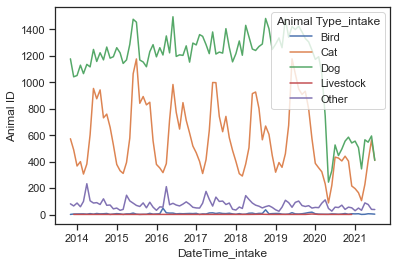

In [91]:
sns.lineplot(x="DateTime_intake", y= 'Animal ID', hue= 'Animal Type_intake', data=intake_animal_count)

Well, we see that at the start of 2020, intakes went down sharply! That correlates well with the start of the COVID-19 pandemic. Let's focus in on the last year. This time I will use ".query" to filter the dataframe based on a logic value. This will return all values that evaluate to True.

In [92]:
intake_animal_count.query("DateTime_intake > '2020-01-01'")

,Animal Type_intake,DateTime_intake,Animal ID
71,Bird,2020-01-31,3
72,Bird,2020-03-31,2
73,Bird,2020-04-30,2
74,Bird,2020-05-31,5
75,Bird,2020-06-30,4
...,...,...,...
380,Other,2021-02-28,32
381,Other,2021-03-31,88
382,Other,2021-04-30,76
383,Other,2021-05-31,39


<AxesSubplot:xlabel='DateTime_intake', ylabel='Animal ID'>

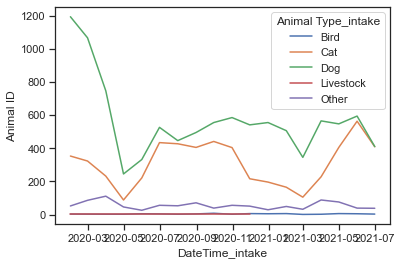

In [93]:
sns.lineplot(x="DateTime_intake",
             y= 'Animal ID',
             hue= 'Animal Type_intake',
             data=intake_animal_count.query("DateTime_intake > '2020-01-01'"))

let's clean this up, remove the hue for the animals so we can just see if the total number of intakes has/will increase by mapping a regression over it.

In [94]:
from datetime import date
inan = animals.groupby([pd.Grouper(key='DateTime_intake', freq='M')])['Animal ID'].count().reset_index()
inan = inan.query("DateTime_intake > '2020-01-01'")
inan['date_ordinal'] = pd.to_datetime(inan['DateTime_intake']).apply(lambda date: date.toordinal())


<AxesSubplot:xlabel='DateTime_intake', ylabel='Animal ID'>

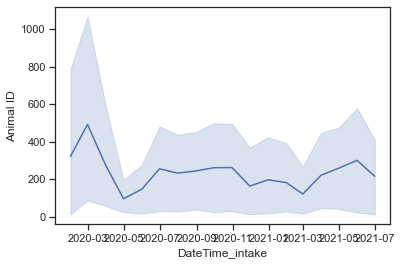

In [95]:
sns.lineplot(x="DateTime_intake",
             y= 'Animal ID',
             data=intake_animal_count.query("DateTime_intake > '2020-01-01'"))

<ipython-input-96-d23c47c454dc>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


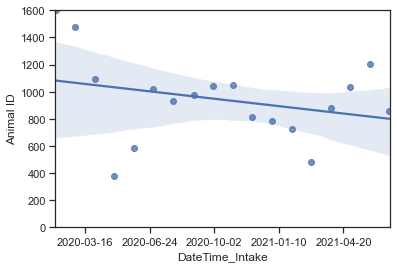

In [96]:
ax = sns.regplot(
    data=inan,
    x='date_ordinal',
    y='Animal ID',
)
# Tighten up the axes for prettiness
ax.set_xlim(inan['date_ordinal'].min() - 1, inan['date_ordinal'].max() + 1)
ax.set_ylim(0, inan['Animal ID'].max() + 1)

ax.set_xlabel('DateTime_Intake')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

plt.show()

Nope, doesn't appear that the shelter is getting more animals at this time.

Let's move on to outcomes

In [97]:
# make a new dataframe with the counts grouped by month of intake and animal tyoe... for this I like using Grouper
outcome_animal_count = animals.groupby(['Animal Type_outcome', pd.Grouper(key='DateTime_outcome', freq='M')])['Animal ID'].count().reset_index()
outcome_animal_count

,Animal Type_outcome,DateTime_outcome,Animal ID
0,Bird,2013-11-30,3
1,Bird,2013-12-31,2
2,Bird,2014-02-28,2
3,Bird,2014-03-31,6
4,Bird,2014-04-30,5
...,...,...,...
379,Other,2021-02-28,29
380,Other,2021-03-31,87
381,Other,2021-04-30,77
382,Other,2021-05-31,46


<ipython-input-98-77dda3dbfccf>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')


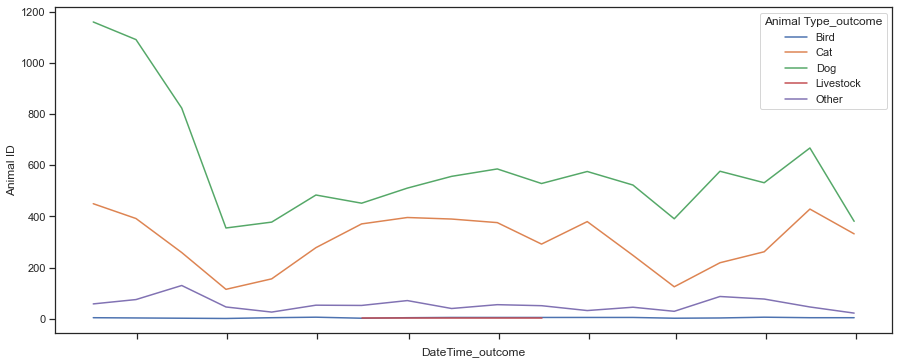

In [98]:
fig, ax = plt.subplots(figsize=(15, 6))
fig = sns.lineplot(x="DateTime_outcome",
             y= 'Animal ID',
             hue= 'Animal Type_outcome',
             data=outcome_animal_count.query("DateTime_outcome > '2020-01-01'"))
labels=ax.get_xticklabels()
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')
plt.show()

In [99]:
onan = animals.groupby([pd.Grouper(key='DateTime_outcome', freq='M')])['Animal ID'].count().reset_index()
onan = onan.query("DateTime_outcome > '2020-01-01'")
onan['date_ordinal'] = pd.to_datetime(onan['DateTime_outcome']).apply(lambda date: date.toordinal())


<AxesSubplot:xlabel='DateTime_outcome', ylabel='Animal ID'>

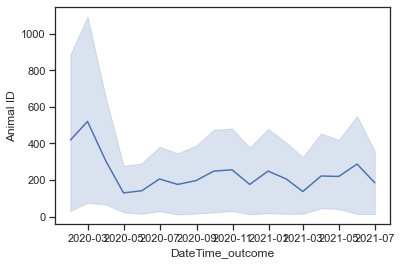

In [100]:
sns.lineplot(x="DateTime_outcome",
             y= 'Animal ID',
             data=outcome_animal_count.query("DateTime_outcome > '2020-01-01'"))

<ipython-input-101-d770389d7dcb>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


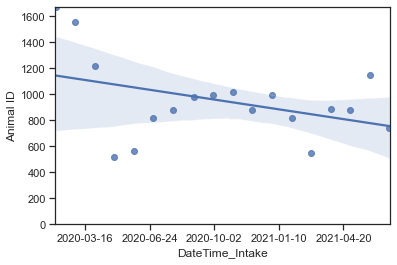

In [101]:
ax = sns.regplot(
    data=onan,
    x='date_ordinal',
    y='Animal ID',
)
# Tighten up the axes for prettiness
ax.set_xlim(onan['date_ordinal'].min() - 1, onan['date_ordinal'].max() + 1)
ax.set_ylim(0, onan['Animal ID'].max() + 1)

ax.set_xlabel('DateTime_Intake')
new_labels = [date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

plt.show()

Ok, so overall. Animal intakes and outcomes are down. Makes sense. Let's drill down to just cats. I'll also use a merge to put the intakes and outcomes on the same graph.

In [102]:
cats=animals[(animals['Animal Type_intake'] == "Cat")].copy()

In [103]:
cats_in = cats.groupby(['Animal Type_intake', pd.Grouper(key='DateTime_intake', freq='M')])['Animal ID'].count().reset_index().rename(columns = {'Animal ID': 'count_in', 'DateTime_intake': 'Date'})

In [104]:
cats_out = cats.groupby(['Animal Type_outcome', pd.Grouper(key='DateTime_outcome', freq='M')])['Animal ID'].count().reset_index().rename(columns={'Animal ID': 'count_out', 'DateTime_outcome':'Date'})

In [105]:
cats_in_out=cats_in.merge(cats_out, on='Date')

In [106]:
cats_in_out=cats_in_out[['Date', 'count_in', 'count_out']]


In [107]:
cats_in_out=pd.melt(cats_in_out, id_vars=['Date'], value_vars=['count_in', 'count_out'])

<AxesSubplot:xlabel='Date', ylabel='value'>

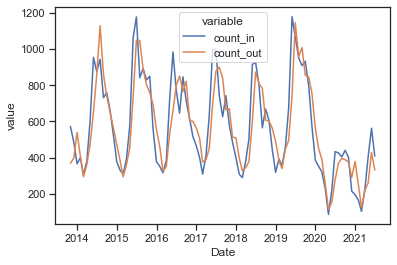

In [108]:
sns.lineplot(x="Date",
             y= 'value',
             hue='variable',
             data=cats_in_out)

<AxesSubplot:xlabel='Date', ylabel='value'>

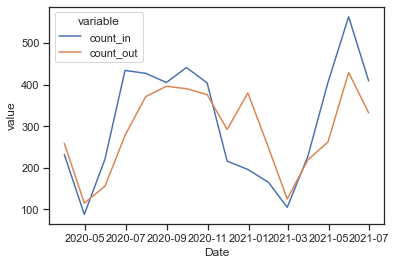

In [109]:
sns.lineplot(x="Date",
             y= 'value',
             hue='variable',
             data=cats_in_out.query("Date >= '03-01-2020'"))

Ok, so cat intakes and outcomes seem to follow each other closely. What about the conditon that cats come to the shelter in?

In [110]:
cats.columns

Index(['Animal ID', 'Name_intake', 'DateTime_intake', 'MonthYear_intake',
       'Found Location', 'Intake Type', 'Intake Condition',
       'Animal Type_intake', 'Sex upon Intake', 'Age upon Intake',
       'Breed_intake', 'Color_intake', 'Name_outcome', 'DateTime_outcome',
       'MonthYear_outcome', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_outcome', 'Sex upon Outcome', 'Age upon Outcome',
       'Breed_outcome', 'Color_outcome', '_merge'],
      dtype='object')

In [111]:
cats_in = cats.groupby([pd.Grouper(key='DateTime_intake', freq='M'), 'Intake Condition'])['Animal ID'].count().reset_index().rename(columns = {'Animal ID': 'count_in', 'DateTime_intake': 'Date'})
cats_in

,Date,Intake Condition,count_in
0,2013-10-31,Aged,3
1,2013-10-31,Feral,4
2,2013-10-31,Injured,31
3,2013-10-31,Normal,491
4,2013-10-31,Nursing,21
...,...,...,...
513,2021-06-30,Medical,3
514,2021-06-30,Normal,296
515,2021-06-30,Nursing,34
516,2021-06-30,Other,1


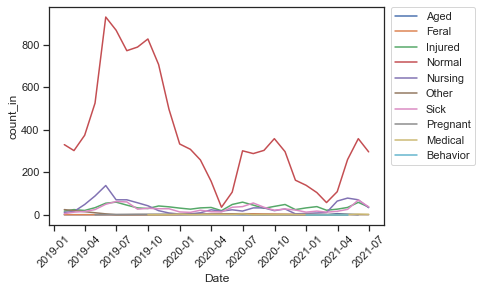

In [112]:
fig=sns.lineplot(x="Date",
             y= 'count_in',
             hue= 'Intake Condition',
             data=cats_in.query("Date > '2019-01-01'"))
for item in fig.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

The reduction in cats is clearly seen in "Normal" cats. But are the other intake types decreasing too?

In [113]:
cats_in = cats.groupby([pd.Grouper(key='DateTime_intake', freq='M'), 'Intake Condition'])['Animal ID'].count()
cat_pcts = cats_in.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [114]:
cat_pcts=cat_pcts.reset_index().rename(columns={'Animal ID':'count', 'DateTime_intake':'Date'})
display(cat_pcts)

,Date,Intake Condition,count
0,2013-10-31,Aged,0.523560
1,2013-10-31,Feral,0.698080
2,2013-10-31,Injured,5.410122
3,2013-10-31,Normal,85.689354
4,2013-10-31,Nursing,3.664921
...,...,...,...
513,2021-06-30,Medical,0.733496
514,2021-06-30,Normal,72.371638
515,2021-06-30,Nursing,8.312958
516,2021-06-30,Other,0.244499


In [115]:
pd.crosstab(cat_pcts['Date'], cat_pcts['Intake Condition'], values=cat_pcts['count'], aggfunc= 'sum', margins = True)

Intake Condition,Aged,Behavior,Feral,Injured,Medical,Normal,Nursing,Other,Pregnant,Sick,All
Date,,,,,,,,,,,
2013-10-31 00:00:00,0.523560,NaN,0.698080,5.410122,NaN,85.689354,3.664921,1.047120,NaN,2.966841,100.0
2013-11-30 00:00:00,NaN,NaN,NaN,4.703476,NaN,90.184049,0.817996,0.204499,NaN,4.089980,100.0
2013-12-31 00:00:00,0.817439,NaN,0.817439,9.264305,NaN,84.741144,0.544959,NaN,NaN,3.814714,100.0
2014-01-31 00:00:00,NaN,NaN,NaN,6.500000,NaN,87.750000,1.250000,0.250000,NaN,4.250000,100.0
2014-02-28 00:00:00,NaN,NaN,NaN,6.535948,NaN,88.235294,1.633987,NaN,NaN,3.594771,100.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 00:00:00,2.631579,0.438596,0.438596,11.842105,0.438596,47.807018,28.508772,NaN,0.438596,7.456140,100.0
2021-04-30 00:00:00,NaN,0.246914,0.246914,8.641975,0.493827,64.197531,19.506173,NaN,0.246914,6.419753,100.0
2021-05-31 00:00:00,0.177620,NaN,NaN,10.479574,0.710480,63.587922,12.611012,NaN,NaN,12.433393,100.0


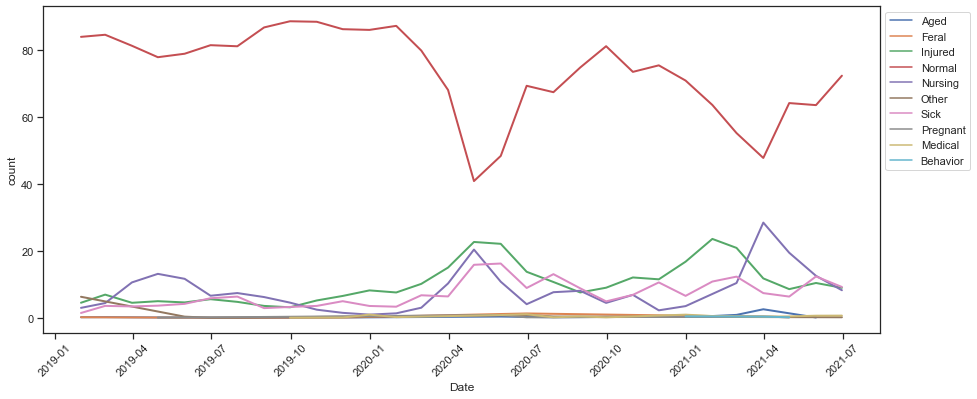

In [116]:
fig, ax = plt.subplots(figsize=(15, 6))
fig=sns.lineplot(x="Date",
             y= 'count',
             hue= 'Intake Condition',
             data=cat_pcts.query("Date > '2019-01-01'"),
                linewidth = 2)
for item in fig.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5, markerscale= 2)
plt.show()

What about outcomes? What is happening to these animals?

In [117]:
cats_out = cats.groupby([pd.Grouper(key='DateTime_outcome', freq='M'), 'Outcome Type'])['Animal ID'].count()
cat_pcts = cats_out.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
cat_pcts=cat_pcts.reset_index().rename(columns={'Animal ID':'Percent', 'DateTime_outcome':'Date'})
display(cat_pcts)
display(pd.crosstab(cat_pcts['Date'], cat_pcts['Outcome Type'], values=cat_pcts['Percent'], aggfunc= 'sum', margins = True))

,Date,Outcome Type,Percent
0,2013-10-31,Adoption,24.594595
1,2013-10-31,Died,1.351351
2,2013-10-31,Euthanasia,10.270270
3,2013-10-31,Return to Owner,2.162162
4,2013-10-31,Transfer,61.621622
...,...,...,...
559,2021-06-30,Disposal,0.301205
560,2021-06-30,Euthanasia,3.012048
561,2021-06-30,Relocate,0.301205
562,2021-06-30,Return to Owner,2.710843


Outcome Type,Adoption,Died,Disposal,Euthanasia,Missing,Relocate,Return to Owner,Rto-Adopt,Transfer,All
Date,,,,,,,,,,
2013-10-31 00:00:00,24.594595,1.351351,NaN,10.270270,NaN,NaN,2.162162,NaN,61.621622,100.0
2013-11-30 00:00:00,43.576826,0.755668,NaN,6.045340,NaN,NaN,7.556675,NaN,42.065491,100.0
2013-12-31 00:00:00,50.185185,0.185185,NaN,4.814815,0.185185,NaN,3.518519,NaN,41.111111,100.0
2014-01-31 00:00:00,44.088670,0.246305,NaN,5.665025,NaN,NaN,12.315271,NaN,37.684729,100.0
2014-02-28 00:00:00,36.610169,1.355932,NaN,7.118644,NaN,NaN,11.186441,NaN,43.728814,100.0
...,...,...,...,...,...,...,...,...,...,...
2021-03-31 00:00:00,47.031963,1.826484,0.456621,5.022831,0.913242,NaN,4.566210,3.196347,36.986301,100.0
2021-04-30 00:00:00,32.824427,0.381679,0.381679,4.198473,NaN,NaN,8.396947,1.145038,52.671756,100.0
2021-05-31 00:00:00,45.920746,3.030303,0.699301,4.195804,NaN,NaN,4.895105,0.699301,40.559441,100.0


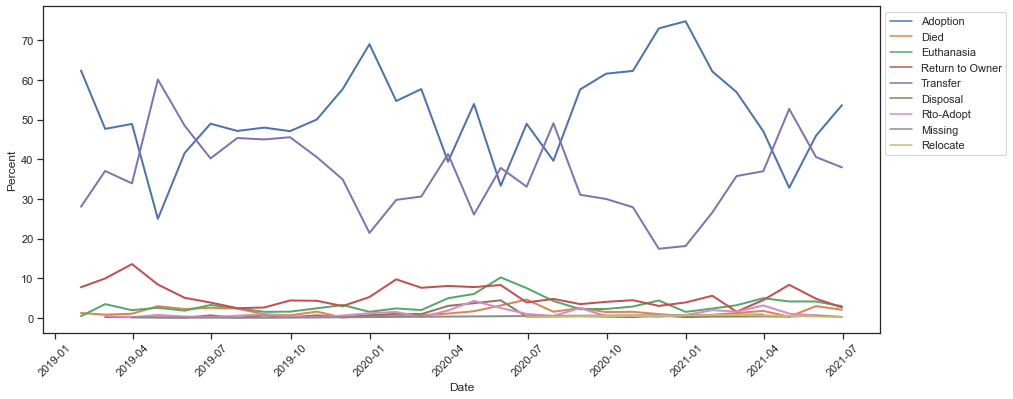

In [118]:
fig, ax = plt.subplots(figsize=(15, 6))
fig=sns.lineplot(x="Date",
             y= 'Percent',
             hue= 'Outcome Type',
             data=cat_pcts.query("Date > '2019-01-01'"),
                linewidth = 2)
for item in fig.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5, markerscale= 2)
plt.show()

# How many days do animals stay at the shelter on average?

In [119]:
recent_intakes.rename(columns={'DateTime': 'intake_date'})

,Animal ID,Name,intake_date,MonthYear,Found Location,Intake Type,Intake Condition,Animal Type,Sex upon Intake,Age upon Intake,Breed,Color
0,A521520,Nina,2013-10-01 07:51:00,10/01/2013 07:51:00 AM,Norht Ec in Austin (TX),Stray,Normal,Dog,Spayed Female,7 years,Border Terrier/Border Collie,White/Tan
1,A664237,NaN,2013-10-01 08:33:00,10/01/2013 08:33:00 AM,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
2,A664236,NaN,2013-10-01 08:33:00,10/01/2013 08:33:00 AM,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
3,A664235,NaN,2013-10-01 08:33:00,10/01/2013 08:33:00 AM,Abia in Austin (TX),Stray,Normal,Cat,Unknown,1 week,Domestic Shorthair Mix,Orange/White
4,A664233,Stevie,2013-10-01 08:53:00,10/01/2013 08:53:00 AM,7405 Springtime in Austin (TX),Stray,Injured,Dog,Intact Female,3 years,Pit Bull Mix,Blue/White
...,...,...,...,...,...,...,...,...,...,...,...,...
114005,A837012,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Unknown,4 weeks,Domestic Shorthair,White/Black
114006,A837006,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Intact Female,1 year,Domestic Shorthair,Black/White
114007,A837009,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Unknown,4 weeks,Domestic Shorthair,Black/White
114008,A837008,NaN,2021-06-17 11:39:00,06/17/2021 11:39:00 AM,Manchaca And Jones Road in Austin (TX),Stray,Normal,Cat,Unknown,4 weeks,Domestic Medium Hair,Black/White


In [120]:
recent_animals = recent_intakes.merge(recent_outcomes, #join intakes to outcomes
              how='outer', # using a left join [so that the animals select have both an intake and a outcome]
              on ='Animal ID',
             suffixes = ('_intake', '_outcome'), # apply these suffixes to the columns with shared names
             indicator= True,
             validate = "one_to_one"
                       )

In [121]:
recent_animals[['Animal ID', 'DateTime_intake', 'DateTime_outcome']]

,Animal ID,DateTime_intake,DateTime_outcome
0,A521520,2013-10-01 07:51:00,2013-10-01 15:39:00
1,A664237,2013-10-01 08:33:00,2013-10-01 10:44:00
2,A664236,2013-10-01 08:33:00,2013-10-01 10:44:00
3,A664235,2013-10-01 08:33:00,2013-10-01 10:39:00
4,A664233,2013-10-01 08:53:00,2013-10-01 15:33:00
...,...,...,...
114819,A622036,NaT,2014-12-16 12:41:00
114820,A658598,NaT,2015-01-24 11:29:00
114821,A663083,NaT,2015-03-10 07:37:00
114822,A620557,NaT,2015-06-22 13:08:00


In [122]:
recent_cats=recent_animals[(recent_animals['Animal Type_intake']== 'Cat')].copy()
recent_cats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45800 entries, 1 to 114009
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Animal ID            45800 non-null  object        
 1   Name_intake          24853 non-null  object        
 2   DateTime_intake      45800 non-null  datetime64[ns]
 3   MonthYear_intake     45800 non-null  object        
 4   Found Location       45800 non-null  object        
 5   Intake Type          45800 non-null  object        
 6   Intake Condition     45800 non-null  object        
 7   Animal Type_intake   45800 non-null  object        
 8   Sex upon Intake      45800 non-null  object        
 9   Age upon Intake      45800 non-null  object        
 10  Breed_intake         45800 non-null  object        
 11  Color_intake         45800 non-null  object        
 12  Name_outcome         24405 non-null  object        
 13  DateTime_outcome     45273 non

In [123]:
recent_cats['shelter_days']=(recent_cats['DateTime_outcome']-recent_cats['DateTime_intake']).dt.days

In [124]:
# Get names of indexes for which column Age has value 30
cat_days_pos=recent_cats.copy()
indexNames = cat_days_pos[ cat_days_pos['shelter_days'] <0 ].index
# Delete these row indexes from dataFrame
cat_days_pos.drop(indexNames , inplace=True)
cat_days_pos
cat_days_pos = cat_days_pos.groupby([pd.Grouper(key='DateTime_outcome', freq='M'), 'Outcome Type'])['shelter_days'].mean().reset_index()

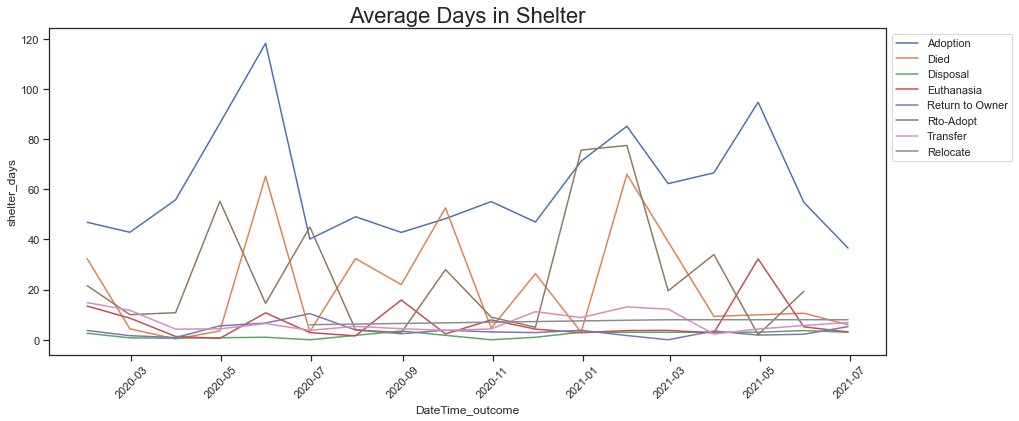

In [125]:
fig, ax = plt.subplots(figsize=(15, 6))
fig=sns.lineplot(x='DateTime_outcome',
             hue='Outcome Type',
             y='shelter_days',
             data=cat_days_pos.query("DateTime_outcome >= '01-01-2020'"))
for item in fig.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5, markerscale= 2)
plt.title('Average Days in Shelter', fontsize=22)
plt.show()

In [130]:
# Get names of indexes for which column Age has value 30
cat_days_pos=recent_cats.copy()
indexNames = cat_days_pos[ cat_days_pos['shelter_days'] <0 ].index
# Delete these row indexes from dataFrame
cat_days_pos.drop(indexNames , inplace=True)
cat_days_pos
print(cat_days_pos.columns)
print(cat_days_pos['Age upon Outcome'].str.split(' ', expand=True))

Index(['Animal ID', 'Name_intake', 'DateTime_intake', 'MonthYear_intake',
       'Found Location', 'Intake Type', 'Intake Condition',
       'Animal Type_intake', 'Sex upon Intake', 'Age upon Intake',
       'Breed_intake', 'Color_intake', 'Name_outcome', 'DateTime_outcome',
       'MonthYear_outcome', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_outcome', 'Sex upon Outcome', 'Age upon Outcome',
       'Breed_outcome', 'Color_outcome', '_merge', 'shelter_days'],
      dtype='object')
          0       1
1         1    week
2         1    week
3         1    week
5         4  months
7        17   years
...     ...     ...
114005  NaN     NaN
114006  NaN     NaN
114007  NaN     NaN
114008  NaN     NaN
114009  NaN     NaN

[45478 rows x 2 columns]


In [135]:
cat_days_pos[['age_int', 'age_mod']] = cat_days_pos['Age upon Outcome'].str.split(' ', expand=True)
cat_days_pos['age_int']=cat_days_pos['age_int'].astype('float')
#map modifiers to the age_mod column
cat_days_pos['age_mod'] = cat_days_pos['age_mod'].map({'weeks':7, 'week': 7, 'months':30, 'month': 30, 'years':365, 'year':365})
# multiply the modifier and the numeric to get the age in days and then drop any of the rows with a null value
cat_days_pos['age_in_days'] = (cat_days_pos['age_mod']*cat_days_pos['age_int'])
cat_days_pos['age_in_days'].dropna(inplace = True)

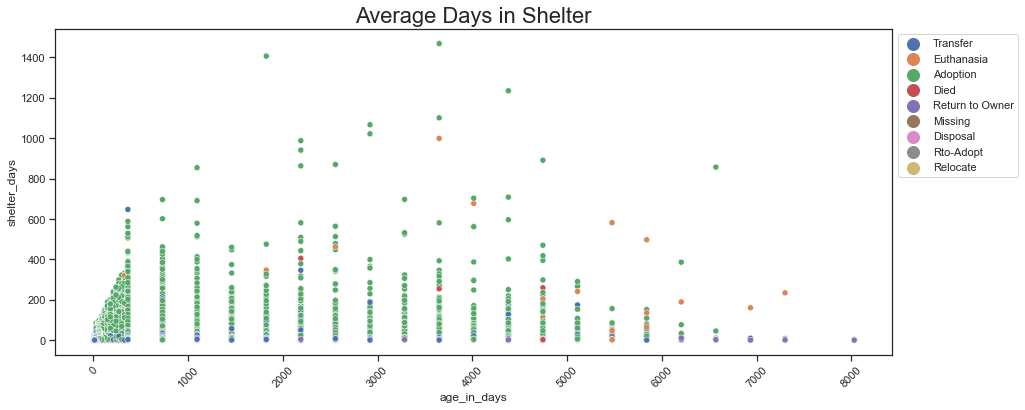

In [136]:
fig, ax = plt.subplots(figsize=(15, 6))
fig = sns.scatterplot(data=cat_days_pos, x="age_in_days", y="shelter_days", hue='Outcome Type')
for item in fig.get_xticklabels():
    item.set_rotation(45)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.5, markerscale= 2)
plt.title('Average Days in Shelter', fontsize=22)
plt.show()

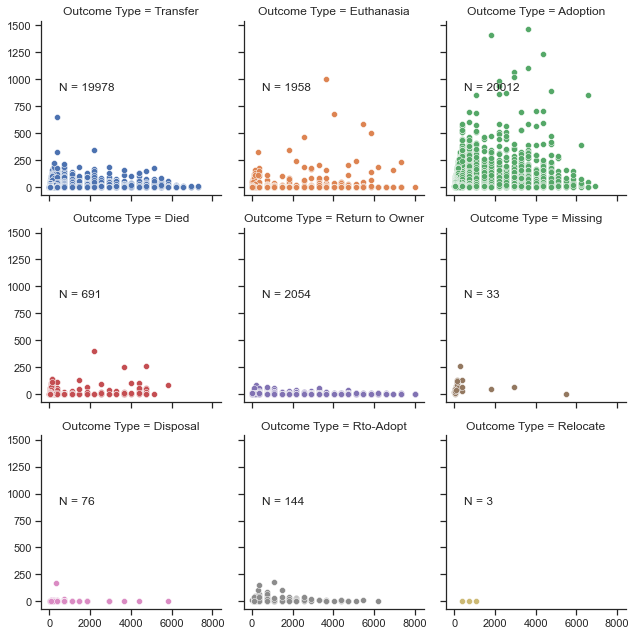

In [137]:
import matplotlib.pyplot as plt
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.1, .6, f"N = {n}", transform=ax.transAxes)

g = sns.FacetGrid(cat_days_pos, col="Outcome Type", col_wrap=3, hue="Outcome Type")
g.map_dataframe(sns.scatterplot, x="age_in_days", y="shelter_days")
g.set_axis_labels("age_in_days", "shelter_days")
g.map_dataframe(annotate)

In [138]:
cat_days_pos.columns

Index(['Animal ID', 'Name_intake', 'DateTime_intake', 'MonthYear_intake',
       'Found Location', 'Intake Type', 'Intake Condition',
       'Animal Type_intake', 'Sex upon Intake', 'Age upon Intake',
       'Breed_intake', 'Color_intake', 'Name_outcome', 'DateTime_outcome',
       'MonthYear_outcome', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_outcome', 'Sex upon Outcome', 'Age upon Outcome',
       'Breed_outcome', 'Color_outcome', '_merge', 'shelter_days', 'age',
       'age_mod', 'age_int', 'age_in_days'],
      dtype='object')

In [161]:
#based on this https://stackoverflow.com/questions/48590488/map-str-contains-across-pandas-dataframe#48590628

burp=cat_days_pos['Breed_intake'].to_frame()

product_map={'short':'short', 'medium':'medium', 'long':'long'}

def like_function(x):
    group = "unknown"
    for key in product_map:
        if key in x:
            group = product_map[key]
            break
    return group

burp['breed'] = burp['Breed_intake'].str.lower().apply(like_function)

In [162]:
burp

,Breed_intake,breed
1,Domestic Shorthair Mix,short
2,Domestic Shorthair Mix,short
3,Domestic Shorthair Mix,short
5,American Shorthair Mix,short
7,Domestic Shorthair Mix,short
...,...,...
114005,Domestic Shorthair,short
114006,Domestic Shorthair,short
114007,Domestic Shorthair,short
114008,Domestic Medium Hair,medium


In [168]:
cat_days_pos = cat_days_pos.join(burp['breed'])
cat_days_pos[['Breed_intake', 'breed']]

,Breed_intake,breed
1,Domestic Shorthair Mix,short
2,Domestic Shorthair Mix,short
3,Domestic Shorthair Mix,short
5,American Shorthair Mix,short
7,Domestic Shorthair Mix,short
...,...,...
114005,Domestic Shorthair,short
114006,Domestic Shorthair,short
114007,Domestic Shorthair,short
114008,Domestic Medium Hair,medium


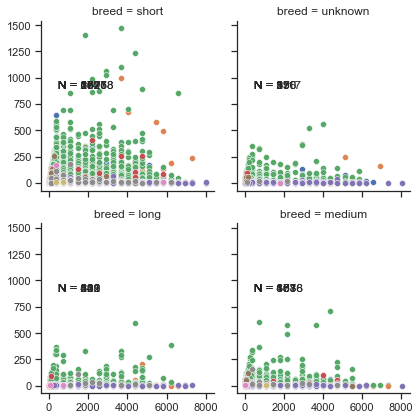

In [172]:
g = sns.FacetGrid(cat_days_pos, col="breed", col_wrap=2, hue="Outcome Type")
g.map_dataframe(sns.scatterplot, x="age_in_days", y="shelter_days")
g.set_axis_labels("age_in_days", "shelter_days")
g.map_dataframe(annotate)

Is there any specific location of note that we should focus resources at?

In [211]:
cat_days_pos['Found Location'].value_counts(normalize=True)*100

Austin (TX)                                    17.221514
Travis (TX)                                     1.248956
7201 Levander Loop in Austin (TX)               0.800387
Outside Jurisdiction                            0.697040
Pflugerville (TX)                               0.439773
                                                 ...    
N Lamar And Koenig Ln in Austin (TX)            0.002199
Turquose Trl & Stonecroft Dr in Austin (TX)     0.002199
1505  E 38Th 1/2 St in Austin (TX)              0.002199
5109 Creekline in Austin (TX)                   0.002199
11709 Spring Head Loop in Austin (TX)           0.002199
Name: Found Location, Length: 17001, dtype: float64

What was the average number of intake per day for each month for the past 5 year?

In [220]:
#What is the number of cats incoming each day
cats_in = cats.groupby([pd.Grouper(key='DateTime_intake', freq='d')])['Animal ID'].count()

In [225]:
cats_month_daily_avg_by_month = cats_in.reset_index().groupby([pd.Grouper(key='DateTime_intake', freq='m')])['Animal ID'].mean()

In [226]:
cats_month_daily_avg_by_month=cats_month_daily_avg_by_month.reset_index().rename(columns={'Animal ID':'countID', 'DateTime_intake':'DateTime'})
cats_month_daily_avg_by_month
cats_month_daily_avg_by_month['year'] = cats_month_daily_avg_by_month['DateTime'].dt.year
cats_month_daily_avg_by_month

,DateTime,countID,year
0,2013-10-31,18.483871,2013
1,2013-11-30,16.300000,2013
2,2013-12-31,11.838710,2013
3,2014-01-31,12.903226,2014
4,2014-02-28,10.928571,2014
...,...,...,...
88,2021-02-28,3.750000,2021
89,2021-03-31,7.354839,2021
90,2021-04-30,13.500000,2021
91,2021-05-31,18.161290,2021


In [238]:
sorted = cats_month_daily_avg_by_month.sort_values(['year', 'countID'])
print('sorted'  + '\n') 
print(sorted)
result = sorted.drop_duplicates('year', keep='last').values
print('result'  + '\n') 
print(result)
col_names=sorted.columns
print('colnames'  + '\n') 
print(col_names)
max_per_year = pd.DataFrame(result, columns=col_names)
print('\n The max average daily intake  - month and year')
display(max_per_year)

sorted

     DateTime    countID  year
2  2013-12-31  11.838710  2013
1  2013-11-30  16.300000  2013
0  2013-10-31  18.483871  2013
4  2014-02-28  10.928571  2014
14 2014-12-31  12.225806  2014
..        ...        ...   ...
87 2021-01-31   5.322581  2021
89 2021-03-31   7.354839  2021
90 2021-04-30  13.500000  2021
91 2021-05-31  18.161290  2021
92 2021-06-30  24.058824  2021

[93 rows x 3 columns]
result

[[Timestamp('2013-10-31 00:00:00') 18.483870967741936 2013]
 [Timestamp('2014-05-31 00:00:00') 30.741935483870968 2014]
 [Timestamp('2015-06-30 00:00:00') 39.2 2015]
 [Timestamp('2016-05-31 00:00:00') 31.70967741935484 2016]
 [Timestamp('2017-06-30 00:00:00') 33.233333333333334 2017]
 [Timestamp('2018-06-30 00:00:00') 30.866666666666667 2018]
 [Timestamp('2019-05-31 00:00:00') 37.96774193548387 2019]
 [Timestamp('2020-09-30 00:00:00') 14.7 2020]
 [Timestamp('2021-06-30 00:00:00') 24.058823529411764 2021]]
colnames

Index(['DateTime', 'countID', 'year'], dtype='object')

 The max ave

,DateTime,countID,year
0,2013-10-31,18.483871,2013
1,2014-05-31,30.741935,2014
2,2015-06-30,39.2,2015
3,2016-05-31,31.709677,2016
4,2017-06-30,33.233333,2017
5,2018-06-30,30.866667,2018
6,2019-05-31,37.967742,2019
7,2020-09-30,14.7,2020
8,2021-06-30,24.058824,2021


Summers are the highest with a max intake of approximatly 30 to 25 cats daily during those months. Now let's figure out how long the average cat stays if they are take in during those months.

In [241]:
cat_days_pos.columns

Index(['Animal ID', 'Name_intake', 'DateTime_intake', 'MonthYear_intake',
       'Found Location', 'Intake Type', 'Intake Condition',
       'Animal Type_intake', 'Sex upon Intake', 'Age upon Intake',
       'Breed_intake', 'Color_intake', 'Name_outcome', 'DateTime_outcome',
       'MonthYear_outcome', 'Date of Birth', 'Outcome Type', 'Outcome Subtype',
       'Animal Type_outcome', 'Sex upon Outcome', 'Age upon Outcome',
       'Breed_outcome', 'Color_outcome', '_merge', 'shelter_days', 'age',
       'age_mod', 'age_int', 'age_in_days', 'breed'],
      dtype='object')

In [249]:
cats_avg_days = cat_days_pos.groupby([pd.Grouper(key='DateTime_intake', freq='m')])['shelter_days'].mean()

In [250]:
cats_avg_days= cats_avg_days.reset_index()
cats_avg_days

,DateTime_intake,shelter_days
0,2013-10-31,17.928846
1,2013-11-30,21.632500
2,2013-12-31,13.887460
3,2014-01-31,11.036184
4,2014-02-28,16.298805
...,...,...
88,2021-02-28,23.583333
89,2021-03-31,15.788660
90,2021-04-30,15.066225
91,2021-05-31,6.340845


In [251]:
year_details = max_per_year.join(cats_avg_days, how='left')

In [258]:
year_details.countID=year_details.countID.astype('float')
year_details.describe()

,countID,shelter_days
count,9.000000,9.000000
mean,28.995783,17.226462
std,8.334692,4.104230
min,14.700000,11.036184
25%,24.058824,14.294494
50%,30.866667,16.298805
75%,33.233333,21.632500
max,39.200000,22.947805


So 17 (average number of days in the shelter) times 28 ( average count of cats),  you will likely want at least:

In [262]:
print("You need approx")
print(17*28)
print("spaces or fosters to hold all the cats you will get at max capcity.")

You need approx
476
spaces or fosters to hold all the cats you will get at max capcity.


In [264]:
cats['DateTime_outcome'].isnull().sum()

527